In [20]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [21]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [22]:
len(X)

1712

In [23]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

In [25]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [26]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(512, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2052      
Total params: 126,876,036
Trainable params: 126,822,916
Non-trainable params: 53,120
_________________________________________________________________


In [27]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [28]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_1_no callback.hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [29]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [30]:
class_weight = {0: 0.8,
                1: 1,
                2: 1,
                3: 1}

In [31]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=200, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint],
            class_weight=class_weight)

Epoch 1/200
43/42 [==============================] - 28s 658ms/step - loss: 1.8233 - acc: 0.2820 - auc_2: 0.5278 - precision_2: 0.2845 - recall_2: 0.1925 - f1score: 0.0951 - val_loss: 23.0210 - val_acc: 0.2362 - val_auc_2: 0.5247 - val_precision_2: 0.2910 - val_recall_2: 0.1592 - val_f1score: nan
Epoch 2/200
43/42 [==============================] - 15s 359ms/step - loss: 1.4192 - acc: 0.3075 - auc_2: 0.5351 - precision_2: 0.3017 - recall_2: 0.1548 - f1score: 0.1040 - val_loss: 2.2613 - val_acc: 0.2653 - val_auc_2: 0.5380 - val_precision_2: 0.2986 - val_recall_2: 0.1415 - val_f1score: 0.0867
Epoch 3/200
43/42 [==============================] - 15s 359ms/step - loss: 1.4131 - acc: 0.3046 - auc_2: 0.5420 - precision_2: 0.3018 - recall_2: 0.1340 - f1score: 0.1039 - val_loss: 1.4567 - val_acc: 0.2449 - val_auc_2: 0.5457 - val_precision_2: 0.3063 - val_recall_2: 0.1250 - val_f1score: 0.0983
Epoch 4/200
43/42 [==============================] - 15s 359ms/step - loss: 1.3494 - acc: 0.3112 - auc

43/42 [==============================] - 15s 359ms/step - loss: 1.1504 - acc: 0.4120 - auc_2: 0.6558 - precision_2: 0.4456 - recall_2: 0.1301 - f1score: 0.1244 - val_loss: 1.2753 - val_acc: 0.3936 - val_auc_2: 0.6569 - val_precision_2: 0.4473 - val_recall_2: 0.1312 - val_f1score: 0.1211
Epoch 29/200
43/42 [==============================] - 15s 359ms/step - loss: 1.1247 - acc: 0.4427 - auc_2: 0.6582 - precision_2: 0.4497 - recall_2: 0.1325 - f1score: 0.1265 - val_loss: 1.2148 - val_acc: 0.4286 - val_auc_2: 0.6596 - val_precision_2: 0.4518 - val_recall_2: 0.1337 - val_f1score: 0.1242
Epoch 30/200
43/42 [==============================] - 15s 360ms/step - loss: 1.1224 - acc: 0.4412 - auc_2: 0.6610 - precision_2: 0.4532 - recall_2: 0.1346 - f1score: 0.1267 - val_loss: 1.2700 - val_acc: 0.4052 - val_auc_2: 0.6622 - val_precision_2: 0.4546 - val_recall_2: 0.1357 - val_f1score: 0.1216
Epoch 31/200
43/42 [==============================] - 15s 359ms/step - loss: 1.1104 - acc: 0.4127 - auc_2: 0.6

43/42 [==============================] - 15s 359ms/step - loss: 1.0542 - acc: 0.4872 - auc_2: 0.7045 - precision_2: 0.4973 - recall_2: 0.1810 - f1score: 0.1344 - val_loss: 1.5058 - val_acc: 0.3819 - val_auc_2: 0.7048 - val_precision_2: 0.4979 - val_recall_2: 0.1819 - val_f1score: 0.1145
Epoch 56/200
43/42 [==============================] - 15s 359ms/step - loss: 1.0454 - acc: 0.4682 - auc_2: 0.7053 - precision_2: 0.4982 - recall_2: 0.1825 - f1score: 0.1344 - val_loss: 1.3440 - val_acc: 0.3761 - val_auc_2: 0.7058 - val_precision_2: 0.4981 - val_recall_2: 0.1833 - val_f1score: 0.1205
Epoch 57/200
43/42 [==============================] - 15s 359ms/step - loss: 1.0345 - acc: 0.4726 - auc_2: 0.7063 - precision_2: 0.4986 - recall_2: 0.1841 - f1score: 0.1354 - val_loss: 1.2830 - val_acc: 0.4169 - val_auc_2: 0.7069 - val_precision_2: 0.4993 - val_recall_2: 0.1850 - val_f1score: 0.1247
Epoch 58/200
43/42 [==============================] - 15s 359ms/step - loss: 1.0582 - acc: 0.4719 - auc_2: 0.7

43/42 [==============================] - 15s 359ms/step - loss: 1.0140 - acc: 0.4755 - auc_2: 0.7268 - precision_2: 0.5174 - recall_2: 0.2136 - f1score: 0.1367 - val_loss: 1.2339 - val_acc: 0.4461 - val_auc_2: 0.7271 - val_precision_2: 0.5177 - val_recall_2: 0.2140 - val_f1score: 0.1280
Epoch 83/200
43/42 [==============================] - 15s 360ms/step - loss: 1.0448 - acc: 0.4653 - auc_2: 0.7274 - precision_2: 0.5178 - recall_2: 0.2145 - f1score: 0.1350 - val_loss: 1.3698 - val_acc: 0.3469 - val_auc_2: 0.7275 - val_precision_2: 0.5176 - val_recall_2: 0.2147 - val_f1score: 0.1200
Epoch 84/200
43/42 [==============================] - 15s 360ms/step - loss: 0.9974 - acc: 0.4901 - auc_2: 0.7279 - precision_2: 0.5177 - recall_2: 0.2150 - f1score: 0.1382 - val_loss: 1.3661 - val_acc: 0.3848 - val_auc_2: 0.7281 - val_precision_2: 0.5178 - val_recall_2: 0.2154 - val_f1score: 0.1231
Epoch 85/200
43/42 [==============================] - 15s 359ms/step - loss: 0.9783 - acc: 0.4945 - auc_2: 0.7

43/42 [==============================] - 15s 359ms/step - loss: 0.9579 - acc: 0.5026 - auc_2: 0.7431 - precision_2: 0.5317 - recall_2: 0.2423 - f1score: 0.1435 - val_loss: 1.1998 - val_acc: 0.4461 - val_auc_2: 0.7433 - val_precision_2: 0.5318 - val_recall_2: 0.2428 - val_f1score: 0.1320
Epoch 110/200
43/42 [==============================] - 15s 360ms/step - loss: 0.9420 - acc: 0.5157 - auc_2: 0.7436 - precision_2: 0.5321 - recall_2: 0.2433 - f1score: 0.1440 - val_loss: 1.2788 - val_acc: 0.4490 - val_auc_2: 0.7439 - val_precision_2: 0.5322 - val_recall_2: 0.2437 - val_f1score: 0.1294
Epoch 111/200
43/42 [==============================] - 15s 360ms/step - loss: 0.9608 - acc: 0.5310 - auc_2: 0.7442 - precision_2: 0.5325 - recall_2: 0.2442 - f1score: 0.1432 - val_loss: 1.2275 - val_acc: 0.4577 - val_auc_2: 0.7444 - val_precision_2: 0.5327 - val_recall_2: 0.2446 - val_f1score: 0.1313
Epoch 112/200
43/42 [==============================] - 15s 359ms/step - loss: 0.9502 - acc: 0.5186 - auc_2: 

43/42 [==============================] - 15s 359ms/step - loss: 0.9164 - acc: 0.5332 - auc_2: 0.7567 - precision_2: 0.5453 - recall_2: 0.2693 - f1score: 0.1467 - val_loss: 1.0859 - val_acc: 0.4723 - val_auc_2: 0.7570 - val_precision_2: 0.5455 - val_recall_2: 0.2697 - val_f1score: 0.1397
Epoch 137/200
43/42 [==============================] - 15s 360ms/step - loss: 0.9302 - acc: 0.5398 - auc_2: 0.7573 - precision_2: 0.5458 - recall_2: 0.2702 - f1score: 0.1479 - val_loss: 1.2023 - val_acc: 0.4286 - val_auc_2: 0.7574 - val_precision_2: 0.5459 - val_recall_2: 0.2707 - val_f1score: 0.1335
Epoch 138/200
43/42 [==============================] - 15s 359ms/step - loss: 0.9128 - acc: 0.5369 - auc_2: 0.7576 - precision_2: 0.5461 - recall_2: 0.2711 - f1score: 0.1471 - val_loss: 1.2084 - val_acc: 0.4752 - val_auc_2: 0.7579 - val_precision_2: 0.5464 - val_recall_2: 0.2716 - val_f1score: 0.1350
Epoch 139/200
43/42 [==============================] - 15s 359ms/step - loss: 0.9292 - acc: 0.5369 - auc_2: 

43/42 [==============================] - 15s 359ms/step - loss: 0.8965 - acc: 0.5464 - auc_2: 0.7681 - precision_2: 0.5563 - recall_2: 0.2929 - f1score: 0.1493 - val_loss: 1.1549 - val_acc: 0.4577 - val_auc_2: 0.7683 - val_precision_2: 0.5565 - val_recall_2: 0.2933 - val_f1score: 0.1381
Epoch 164/200
43/42 [==============================] - 15s 359ms/step - loss: 0.8786 - acc: 0.5654 - auc_2: 0.7685 - precision_2: 0.5567 - recall_2: 0.2937 - f1score: 0.1517 - val_loss: 1.1245 - val_acc: 0.4781 - val_auc_2: 0.7687 - val_precision_2: 0.5569 - val_recall_2: 0.2942 - val_f1score: 0.1392
Epoch 165/200
43/42 [==============================] - 15s 359ms/step - loss: 0.8874 - acc: 0.5522 - auc_2: 0.7689 - precision_2: 0.5570 - recall_2: 0.2945 - f1score: 0.1508 - val_loss: 1.1304 - val_acc: 0.4985 - val_auc_2: 0.7691 - val_precision_2: 0.5573 - val_recall_2: 0.2949 - val_f1score: 0.1401
Epoch 166/200
43/42 [==============================] - 15s 359ms/step - loss: 0.8959 - acc: 0.5551 - auc_2: 

43/42 [==============================] - 15s 359ms/step - loss: 0.8443 - acc: 0.5814 - auc_2: 0.7778 - precision_2: 0.5660 - recall_2: 0.3145 - f1score: 0.1554 - val_loss: 1.2458 - val_acc: 0.4869 - val_auc_2: 0.7780 - val_precision_2: 0.5662 - val_recall_2: 0.3149 - val_f1score: 0.1385
Epoch 191/200
43/42 [==============================] - 15s 360ms/step - loss: 0.8347 - acc: 0.5836 - auc_2: 0.7782 - precision_2: 0.5663 - recall_2: 0.3153 - f1score: 0.1560 - val_loss: 1.2411 - val_acc: 0.4606 - val_auc_2: 0.7784 - val_precision_2: 0.5665 - val_recall_2: 0.3157 - val_f1score: 0.1360
Epoch 192/200
43/42 [==============================] - 15s 360ms/step - loss: 0.8351 - acc: 0.5924 - auc_2: 0.7785 - precision_2: 0.5667 - recall_2: 0.3161 - f1score: 0.1567 - val_loss: 1.1664 - val_acc: 0.5131 - val_auc_2: 0.7787 - val_precision_2: 0.5669 - val_recall_2: 0.3165 - val_f1score: 0.1418
Epoch 193/200
43/42 [==============================] - 15s 359ms/step - loss: 0.8341 - acc: 0.5924 - auc_2: 

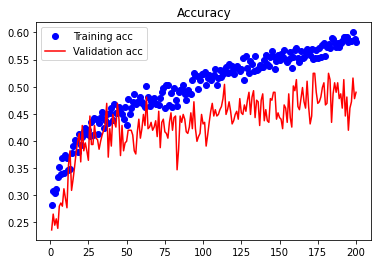

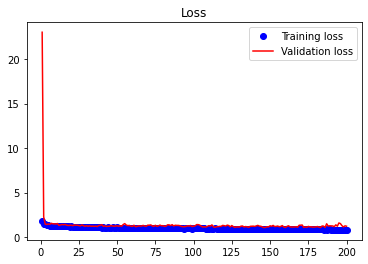

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [33]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 1s 3ms/step
loss: 1.214, accuracy: 0.490, auc: 0.781, precision: 0.570, recall: 0.323, f1score: 0.140


In [34]:
from keras.models import Model, load_model

new_model = models.load_model('ResNet_1_no callback.hdf5',compile=False)


new_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [35]:
_loss, _acc, _auc, _precision, _recall, _f1score = new_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

343/343 [==============================] - 2s 7ms/step
loss: 1.062, accuracy: 0.490, auc: 0.792, precision: 0.523, recall: 0.359, f1score: 0.142
